In [2]:
!pip install koreanize_matplotlib

In [23]:
## 1. 필요 모듈 불러오기
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [5]:
!pip install scikit-learn

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.2/10.6 MB 35.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/10.6 MB 16.3 MB/s eta 0:00:01
   ------ --------------------------------- 1.7/10.6 MB 13.2 MB/s eta 0:00:01
   ------------- -------------------------- 3.5/10.6 MB 20.0 MB/s eta 0:00:01
   ------------------------------- -------- 8.2/10.6 MB 37.5 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 40.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---------------------------------------- 301.2/301.2 kB ? eta 0:00:00


In [24]:
## 2. 데이터 셋 가져오기 -> data/resnet_data 의 이미지 가져오기 // Image_1, 2, 3 .jpg -> label : 마동석
from sklearn.model_selection import train_test_split        # 필요 모듈 불러오기
# 80 : 10 : 10 분리하는 게 쉬움


In [25]:
dataset = ImageFolder(root= "../data/resnet_data")

# dataset


# for i in dataset:
#     print(i)

dataset.class_to_idx

{'박보영': 0, '차은우': 1, '카리나': 2}

In [26]:
## 데이터셋 분할 난수 설정
seed_num = 0 # 분할 난수 설정
np.random.seed(seed_num)  # numpy의 난수 생성기 시드 고정
torch.manual_seed(seed_num)  # PyTorch의 난수 생성기 시드 고정

# 폴더에서 데이터 불러오기
dataset = ImageFolder(root='../data/resnet_data/')
dataset_indices = list(range(len(dataset)))

# train/val/test -> 80/10/10
# 데이터셋의 레이블만 추출
targets = dataset.targets # 전체 데이터셋의 label 가져오기
print(targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [27]:
# 첫번째 분할하기 train: val+test -> 80:20
train_indices, val_test_indices = train_test_split(dataset_indices, test_size=0.2, stratify=targets, random_state=seed_num)
val_test_target= [targets[i] for i in val_test_indices]

In [28]:
# 두번째 분할하기 val: test -> 10:10
val_idx, test_idx = train_test_split(val_test_indices, test_size=0.5, stratify=val_test_target, random_state=seed_num)

In [29]:
# Subset을 사용하여 최종 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [30]:
print(len(dataset), len(train_dataset), len(val_dataset), len(test_dataset))

120 96 12 12


In [31]:
## 확인해보기
class_idx = dataset.class_to_idx

# for i in class_idx.items():
#     print(i)

class_names = {}
# for key, value in class_idx.items():
#     class_names[value] = key

class_names = dict([(value, key) for key, value in class_idx.items()])
class_names

{0: '박보영', 1: '차은우', 2: '카리나'}

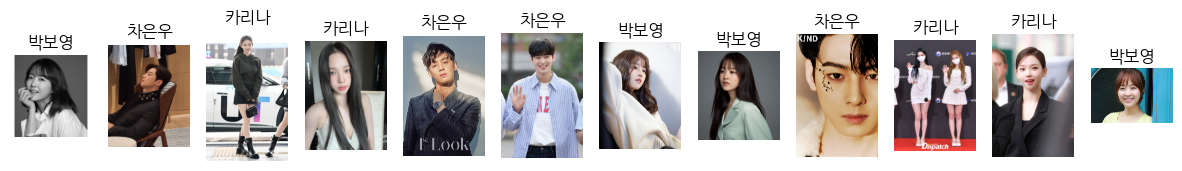

In [32]:
plt.figure(figsize=(15,8))
for idx, item in enumerate(test_dataset, start=1):
    plt.subplot(1,len(test_dataset),idx)
    image = item[0]
    class_name = class_names[item[1]] # 변환한 딕셔너리
    plt.title(class_name)
    plt.axis('off')  # 축과 눈금 제거
    plt.imshow(image)

In [33]:
## 3. 이미지 증강 및 전처리 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [34]:
# 데이터 증강 transform 적용
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [35]:
## data_loader 정의
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [48]:
# 모델 학습하기
model_ResNet = models.resnet18(weights=None, num_classes=4)
device = torch.device("cuda")
model_ResNet.to(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# 손실함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

In [50]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        # 학습 데이터에 대한 반복
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU 로 이동

            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU 로 이동

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f}')

    return train_losses, val_losses

In [51]:
history = train_and_validate(model_ResNet, train_loader, val_loader, optimizer, criterion, epochs=100)

Epoch [1/100] - Training loss: 1.720
Epoch [1/100] - Validation loss: 15.849
Epoch [2/100] - Training loss: 1.276
Epoch [2/100] - Validation loss: 1.642
Epoch [3/100] - Training loss: 1.183
Epoch [3/100] - Validation loss: 1.435
Epoch [4/100] - Training loss: 1.092
Epoch [4/100] - Validation loss: 1.095
Epoch [5/100] - Training loss: 1.138
Epoch [5/100] - Validation loss: 0.923
Epoch [6/100] - Training loss: 1.052
Epoch [6/100] - Validation loss: 1.181
Epoch [7/100] - Training loss: 1.079
Epoch [7/100] - Validation loss: 1.409
Epoch [8/100] - Training loss: 1.091
Epoch [8/100] - Validation loss: 1.078
Epoch [9/100] - Training loss: 1.066
Epoch [9/100] - Validation loss: 1.020
Epoch [10/100] - Training loss: 1.042
Epoch [10/100] - Validation loss: 1.467
Epoch [11/100] - Training loss: 1.036
Epoch [11/100] - Validation loss: 1.225
Epoch [12/100] - Training loss: 1.147
Epoch [12/100] - Validation loss: 1.110
Epoch [13/100] - Training loss: 1.097
Epoch [13/100] - Validation loss: 0.863
Epo

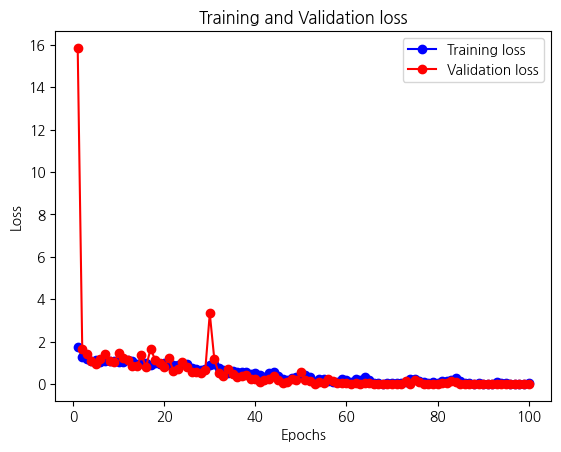

In [52]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
def display_history(history):
    train_losses, val_losses = history
    # 에포크 번호를 기준으로 그래프를 그립니다.
    epochs = range(1, len(train_losses) + 1)

    # 학습 및 검증 손실 그래프 그리기
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
display_history(history)

In [53]:
import torchmetrics

def evaluate(model, loader):
    model.to(device) # 모델을 GPU 로 이동
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)

    accuracy = accuracy_metric.compute()  # 정확도 계산
    
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()

In [54]:
evaluate(model_ResNet, test_loader)

테스트 이미지 정확도 계산: 100.00%


1.0

In [55]:
# 저장된 모델 불러오기
load_model_best = models.resnet18(weights=None, num_classes=4)
load_model_best.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [56]:
evaluate(load_model_best, test_loader)

테스트 이미지 정확도 계산: 6.25%


0.0625

In [47]:
# 모델 설정
model_ResNet_best = models.resnet18(weights=None, num_classes=4)

# 손실함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet_best.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_validate_best(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)                # 모델을 GPU 로 이동

    train_losses = []
    val_losses = []
    
    min_val_loss = float('inf')     # 가장 좋은 모델을 추적하기 위한 변수 초기화
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # 검증 과정
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}, Validation loss: {epoch_val_loss:.3f}')
        
        # 가장 좋은 모델만 저장
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'best 모델 저장 {epoch}.')
    
    return train_losses, val_losses

In [ ]:
history_best = train_and_validate_best(model_ResNet_best, train_loader, val_loader, optimizer, criterion, epochs=100)

In [ ]:
display_history(history_best)